In [2]:
import re
#from gensim import corpora
#import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import tqdm
import zlib
import base64
import os
import nltk
import pandas as pd
#from summarizer import Summarizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer

from sentence_transformers import SentenceTransformer
import numpy as np


from nltk import bigrams

/home/gustavo/Documents/tcc/Fed-speak/tcc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

dir_speeches  = 'compressed_fomc_minutes'


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/gustavo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gustavo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gustavo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def preprocess_text(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Remove duplicate tokens
    tokens = list(dict.fromkeys(tokens))  # Remove duplicates while preserving order
    return ' '.join(tokens)

In [5]:
documents = {}
#read all files in the directory
for filename in os.listdir(dir_speeches):
    if filename.endswith('.txt'):
        with open(os.path.join(dir_speeches, filename), 'r', encoding="utf8") as file:
            text = file.read()
            #print('Original Text:', text)
            decompressed = zlib.decompress(base64.b64decode(text.encode())).decode()
            decompressed = preprocess_text(decompressed)
            
            # make decompressed into a string
           
            documents[filename] = decompressed
            


In [6]:
# make dataframe
df = pd.DataFrame.from_dict(documents, orient='index')
df['time'] = df.index.str.replace('.txt', '').str.replace('compressed_fomc_minutes', ' ')
df['time'] = pd.to_datetime(df['time'])
df.index = range(len(df))
df = df.sort_values(by='time')
print(df.head())

                                                     0       time
36   meeting federal open market committee held off... 2000-02-02
115  meeting federal open market committee held off... 2000-03-21
131  meeting federal open market committee held off... 2000-05-16
1    meeting federal open market committee held off... 2000-06-28
16   meeting federal open market committee held off... 2000-08-22


In [7]:
df['t+1'] = df['time'].shift(-1)
df['t+2'] = df['time'].shift(-2)
df["Text"] = df[0]


In [8]:
#get interest rate data 

df_economic_data = pd.read_csv('DFEDTAR.csv', index_col=0)
#date, value
df_economic_data.index = pd.to_datetime(df_economic_data.index)
df_economic_data.reset_index(inplace=True)
#get the interest rate for the values in df
df['t+1'] = pd.to_datetime(df['t+1'])

#match the interest rate to the meeting date in df
merged_df = pd.merge(df[['Text', 'time']], df_economic_data.reset_index(), left_on='time', right_on='DATE', how='left')
#rename DFEDTAR to IR
merged_df = merged_df.rename(columns={'DFEDTAR': 'rate'})
merged_df.head()

,Text,time,index,DATE,rate
0,meeting federal open market committee held off...,2000-02-02,154,2000-02-02,5.75
1,meeting federal open market committee held off...,2000-03-21,202,2000-03-21,6.00
2,meeting federal open market committee held off...,2000-05-16,258,2000-05-16,6.50
3,meeting federal open market committee held off...,2000-06-28,301,2000-06-28,6.50
4,meeting federal open market committee held off...,2000-08-22,356,2000-08-22,6.50


In [9]:
merged_df['rateChange'] = merged_df['rate'].shift(-1) - merged_df['rate']
# Drop rows with NaN values in 'rateChange' (optional, depending on your needs)
merged_df.dropna(subset=['rateChange'], inplace=True)
merged_df.drop('index', axis=1, inplace=True)

#  drop the redundant time column after merging
merged_df.drop('time', axis=1, inplace=True)
#drop index


In [10]:
#save df to csv
merged_df.to_csv('merged_df.csv', index=False)

In [14]:
#Step 2: Generate Sentence Embeddings with SBERT
import torch
import torch.nn as nn
import torch.optim as optim
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, f1_score
#get xgboost model
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Load the pre-trained Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # You can use other pre-trained models as well

# Example sentences (replace these with sentences from FED publications)
sentences = merged_df['Text'].values

# Generate embeddings for the sentences
embeddings = model.encode(sentences)

# Convert embeddings to numpy array for easier handling
embeddings = np.array(embeddings)

# Load the data
x = embeddings
y_num = merged_df['rateChange']
y = [1 if x > 0 else 0 if x == 0 else 2 for x in y_num]


## XGBOOST WITH VALUES

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import xgboost as xgb

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y_num, test_size=0.4, random_state=42
)

Mean Squared Error (MSE): 0.06842160114553193
Root Mean Squared Error (RMSE): 0.2615752303746131
Mean Absolute Error (MAE): 0.1770954367843783
R^2 Score: 0.04603956921373609


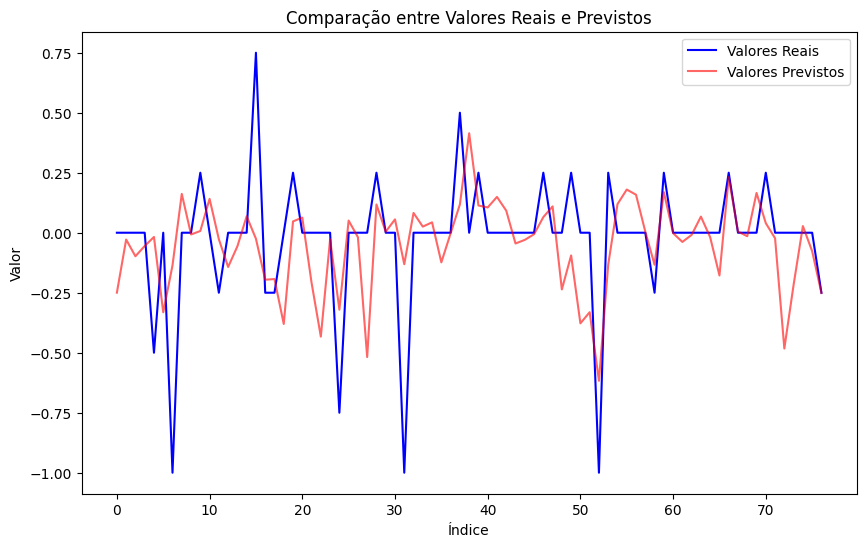

In [22]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Supondo que você já tenha dividido os dados em X_train, X_test, y_train, y_test

# Create the DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for regression
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.3,
    'gamma': 0,
    'reg_lambda': 1,
    'alpha': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Train the model
bst = xgb.train(params, dtrain, num_boost_round=1000)

# Make predictions
y_pred = bst.predict(dtest)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test)), y_test, color='blue', label='Valores Reais')
plt.plot(np.arange(len(y_test)), y_pred, color='red', label='Valores Previstos', alpha=0.6)
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()

##XGBOOST CLASS

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import xgboost as xgb

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

In [39]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 6, 9, 12],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'lambda': [0, 0.1, 1.0],
    'alpha': [0, 0.1, 1.0]
}

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=3)
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', cv=3, verbose=3)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Fitting 3 folds for each of 11664 candidates, totalling 34992 fits
[CV 1/3] END alpha=0, colsample_bytree=0.6, gamma=0, lambda=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.745 total time=   0.3s
[CV 2/3] END alpha=0, colsample_bytree=0.6, gamma=0, lambda=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.765 total time=   0.3s
[CV 3/3] END alpha=0, colsample_bytree=0.6, gamma=0, lambda=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.740 total time=   0.3s
[CV 1/3] END alpha=0, colsample_bytree=0.6, gamma=0, lambda=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.706 total time=   0.3s
[CV 2/3] END alpha=0, colsample_bytree=0.6, gamma=0, lambda=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.667 total time=   0.3s
[CV 3/3] END alpha=0, colsample_bytree=0.6, gamma=0, lambda=0, learning_rate=0.01, max_depth=3, min_child_weight=1, su

KeyboardInterrupt: 

In [ ]:
y_pred = grid_search.predict(X_test)

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.88      0.78      0.82        27
           1       0.50      0.60      0.55         5
           2       0.56      0.71      0.62         7

    accuracy                           0.74        39
   macro avg       0.64      0.70      0.66        39
weighted avg       0.77      0.74      0.75        39



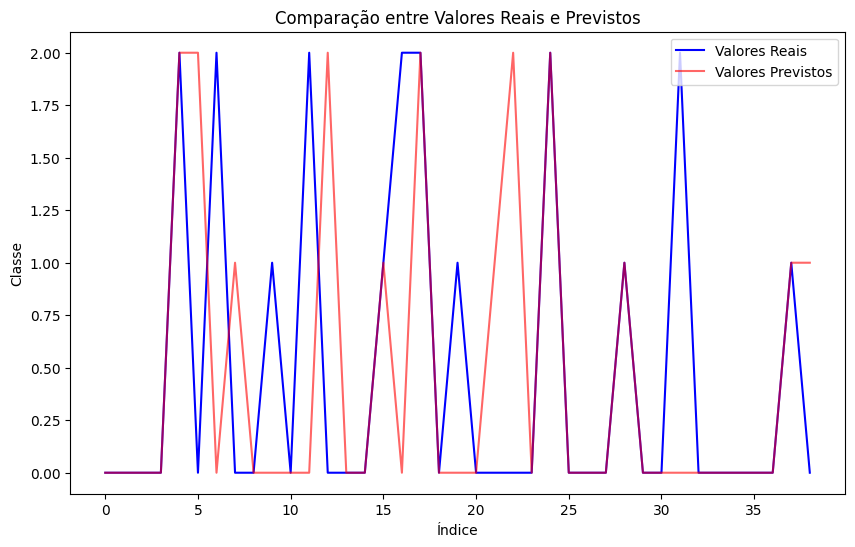

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que você já tenha treinado o modelo e feito as previsões

# Crie um gráfico de linha comparando os valores reais e previstos
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test)), y_test, color='blue', label='Valores Reais')
plt.plot(np.arange(len(y_test)), y_pred, color='red', label='Valores Previstos', alpha=0.6)
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Índice')
plt.ylabel('Classe')
plt.legend()
plt.show()

In [ ]:

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)


# Calculate the scale_pos_weight
class_counts = np.bincount(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]

# Define the XGBoost model with scale_pos_weight
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', seed=42, scale_pos_weight=scale_pos_weight)
# Define parameter grid for GridSearch
param_grid = {
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'lambda': [0, 0.1, 1.0]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters: ", grid_search.best_params_)
print("Best F1 Score: ", grid_search.best_score_)

# Use the best model to predict on the test set
best_model = grid_search.best_estimator_
preds = best_model.predict(X_test)



Fitting 3 folds for each of 729 candidates, totalling 2187 fits


KeyboardInterrupt: 

In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import xgboost as xgb
import numpy as np

# Define the best parameters
best_params = {
    'base_score': 0.75,
    'booster': 'gbtree',
    'learning_rate': 0.05,
    'max_depth': 3,
    'min_child_weight': 3,
    'n_estimators': 100
}

# Set up the model with the best parameters
model = xgb.XGBClassifier(
    base_score=best_params['base_score'],
    booster=best_params['booster'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    n_estimators=best_params['n_estimators'],
    objective='multi:softmax',
    num_class=3,  # Adjust based on the number of classes
    eval_metric='mlogloss'
)

# Define the KFold cross-validation (e.g., 5-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store F1 scores for each fold
f1_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    # Train the model
    model.fit(X_train_fold, y_train_fold)
    
    # Make predictions
    preds = model.predict(X_test_fold)
    
    # Calculate F1 score for this fold
    f1 = f1_score(y_test_fold, preds, average='weighted')
    f1_scores.append(f1)

# Print the F1 scores for each fold and the average
print("F1 Scores for each fold: ", f1_scores)
print("Average F1 Score: ", np.mean(f1_scores))


TypeError: only integer scalar arrays can be converted to a scalar index

In [35]:
# Evaluate the model
f1 = f1_score(y_test, preds, average='weighted')
print(f'F1 Score: {f1:.4f}')
print(classification_report(y_test, preds))

F1 Score: 0.7879
              precision    recall  f1-score   support

           0       0.84      0.87      0.86        55
           1       0.67      0.50      0.57        12
           2       0.64      0.70      0.67        10

    accuracy                           0.79        77
   macro avg       0.72      0.69      0.70        77
weighted avg       0.79      0.79      0.79        77

